In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

In [3]:
cd /content/drive/MyDrive/2048 Final

/content/drive/MyDrive/2048 Final


In [4]:
import math, random
from collections import deque

import game_2048
import Group

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

In [5]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
#m1에서 돌릴 때 GPU 사용을 위한 code...I'll do later.
#mps_device = torch.device("mps")

In [30]:
num_frames = 100000
batch_size = 256
gamma = 0.99

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen = capacity)
    
    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state,0)
        #1x4를 1x1x4로 making for multithreading
        next_state = np.expand_dims(next_state,0)
        
        self.buffer.append((state,action,reward,next_state,done)) #deque에 numpy arr이 들어간다는 사실
        
    def sample(self,batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        #concaternate를 return한다는 것이 무슨 뜻이지?
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [10]:
env = game_2048.Game2048()

In [45]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 10000

#단순 1/500이 아니라 exp(-x/500)
epsilon_by_frame = lambda frame_idx : epsilon_final + (epsilon_start - epsilon_final)*math.exp(-1.*frame_idx/epsilon_decay)


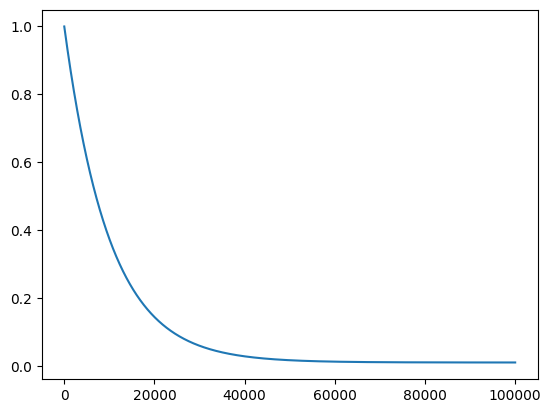

In [47]:
plt.plot([epsilon_by_frame(i) for i in range(100000)])

# Deep Q Network

In [39]:
class DQN(nn.Module):
    def __init__(self,num_inputs,num_actions):
        super(DQN, self).__init__() #nn.Module class의 init
        
        #함수 pointer 같은 것
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,padding=1),
            nn.GELU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,kernel_size=3,padding=1),
            nn.GELU(),
            nn.BatchNorm2d(32),
          )
        self.layer_fc = nn.Sequential(
            nn.Linear(1024,512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Linear(512,256),
            nn.GELU(),
            nn.BatchNorm1d(256),
            nn.Linear(256,128),
            nn.GELU(),
            nn.BatchNorm1d(128),
            nn.Linear(128,50),
            nn.GELU(),
            nn.BatchNorm1d(50),
            nn.Linear(50,num_actions),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32,48,kernel_size=3,padding=1),
            nn.GELU(),
            nn.BatchNorm2d(48),
            nn.Conv2d(48,64,kernel_size=3,padding=1),
            nn.GELU(),
            nn.BatchNorm2d(64),
          )
        
    def forward(self, x):
        x = self.layer1(x)+x
        x = self.layer2(x)
        x = x.view(-1,16*64)
        return self.layer_fc(x)

    def act(self,state,epsilon):
        #epsilon-greedy
        if np.random.rand(1)[0] > epsilon:
            state = torch.tensor(state,dtype=torch.float32)#0번 자리에 차원 하나 추가
            state = state.to(device)
            #state = torch.flatten(state)
            state = state.unsqueeze(0)
            state = state.unsqueeze(0)
            q_value = self.forward(state)
            #1X2로부터 최대를 구하기 위해 row의 최대 .max(1) max인 것의[1]은 idx, 요거는 하나이므로 .data[0]
            action = int(q_value.max(1)[1]) #q_value의 second dim에서 Q_value와 index를 묶은 tuple을

        else:
            action = random.randrange(4)
        return action

In [40]:
local_network = DQN(16,4)
target_network = DQN(16,4)

local_network = local_network.to(device)
target_network = target_network.to(device)

optimizer = optim.Adam(local_network.parameters())

replay_buffer = ReplayBuffer(1024)

# Computing Temporal Difference Loss

In [41]:
def compute_td_loss(batch_size):
    local_network.train()

    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state = torch.tensor(state,dtype=torch.float32).to(device)
    state = state.view([batch_size,1,4,4])
    next_state = torch.tensor(next_state,dtype=torch.float32).to(device)
    next_state = state.view([batch_size,1,4,4])
    action = torch.tensor(action,dtype=torch.int64).unsqueeze(1)
    action = action
    action = action.to(device)
    reward = torch.tensor(reward,dtype=torch.float32).to(device)
    done = torch.tensor(done,dtype=torch.float32).to(device)
    #print(state.shape)
    q_values = local_network(state)
    next_q_values = target_network(next_state)
    #print(next_q_values)
    q_value = torch.gather(q_values,1,action)
    
    next_q_value = next_q_values.max(1)[0] #제일 큰 값으로 선택
    
    expected_q_value = reward + gamma *next_q_value*(1-done) ##DDQN시 여기 수정
    q_value = q_value.squeeze(1)
    loss_func = nn.MSELoss()
    loss = loss_func(expected_q_value,q_value)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss
    

In [42]:
def plot(frame_idx,losses,rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx,rewards[-1]))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

# Training

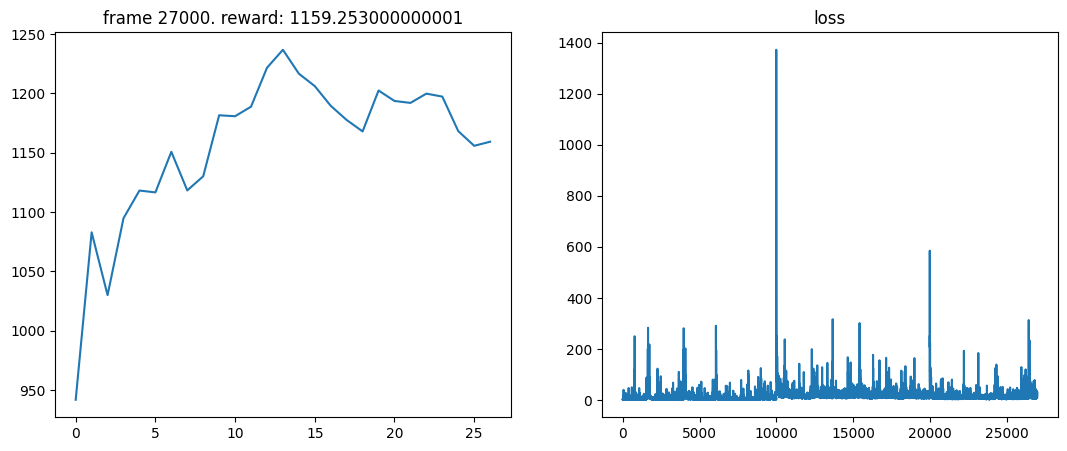

In [ ]:
losses = []
all_rewards = deque(maxlen = 100)
mean_rewards = []
episode_reward = 0
count = 0
env.reset()
state = env.board
for frame_idx in range(1,num_frames+1):
    epsilon = epsilon_by_frame(frame_idx) #epsilon update
    
    local_network.eval()
    with torch.no_grad():
        #print(state)
        convert_direction = Group.representative(state)
        converted_state = Group.rotate(state,convert_direction)
        converted_action = local_network.act(converted_state,epsilon)
        action = Group.action_convert(convert_direction,converted_action)
    
    #print(action)
    next_state, reward, done = env.step(int(action))
#     print(state)
#     print("next : \n",next_state)
    #개선 여지 있음.(tile이 바뀌지 않은 경우, 시간이 오래 걸릴 수 있음,continue로 개선 여지 있음.)
    
    convert_direction = Group.representative(next_state)
    converted_next_state = Group.rotate(next_state,convert_direction)
    replay_buffer.push(converted_state,converted_action,reward,converted_next_state,done)
    
    state = next_state
    episode_reward += reward
    if done:
        env.reset()
        state = env.board
        all_rewards.append(episode_reward)
        episode_reward = 0
    
    if len(replay_buffer.buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        #print(loss)
        losses.append(loss.item())

    
    if frame_idx %1000 == 0:
        mean_rewards.append(np.mean(all_rewards))
        plot(frame_idx, losses,mean_rewards)
    
    if frame_idx %10000 == 0:
        target_network.load_state_dict(local_network.state_dict())

In [ ]:
qvalue = torch.tensor([1,2,3,4],dtype = torch.float32)

In [ ]:
qvalue.max(0)[1]